In [1]:
import torch
import numpy as np
import models,utils,camera
import matplotlib.pyplot as plt
from tqdm import tqdm
import datasets
import matplotlib.pyplot as plt
from camera import Camera_v2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = datasets.GSO(r"C:\Users\Admin\Documents\Dataset\GSO_image",output_image=3)
cam  = Camera_v2(35,35,32,32)


BATCH_SIZE = 14
LEARNING_RATE = 0.0001
EPOCH = 2000

c:\Users\Admin\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = models.MultiViewDiffusionModel().to(device)
model = torch.load('diffusion_best4.pth').to(device)

tensor([1.0012, 1.0038, 1.0079, 1.0137, 1.0216, 1.0320, 1.0455, 1.0630, 1.0864,
        1.1203])

In [3]:
loader = torch.utils.data.DataLoader(dataset,
                                    batch_size=BATCH_SIZE, shuffle=True,
                                    num_workers=4,drop_last = True)


optimizer = torch.optim.AdamW(list(model.parameters()),lr=LEARNING_RATE)
loss = torch.nn.MSELoss(reduce="mean")



c:\Users\Admin\anaconda3\envs\torch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [4]:
model.train()
for epoch in range(EPOCH):
    mean = 0
    train_loop = tqdm(loader)
    for i,batch in enumerate(train_loop):
        l = 0
        X=batch['X'].to(device)
        Y = batch['Y'].to(device)
        relative_M = batch['relative_M'].to(device)
        predicted_noise,noise = model.train_loop(X,Y,relative_M)
        #l += ((predicted_noise[...,:3,:,:]-noise[...,:3,:,:])**2).mean()
        l += ((predicted_noise[...,:3,:,:]-noise[...,:3,:,:])**2*Y[...,-1:,:,:]).mean()
        l += ((predicted_noise[...,-1:,:,:]-noise[...,-1:,:,:])**2).mean()
        mean += float(l)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        train_loop.set_description(f"training {epoch+1}/{EPOCH}")
        train_loop.set_postfix(loss_task = float(l),tot_loss=mean/(i+1)/0.004)

training 51/2000:  84%|████████▎ | 61/73 [00:16<00:03,  3.64it/s, loss_task=0.173, tot_loss=55.1] 


KeyboardInterrupt: 

In [5]:
torch.save(model,'diffusion_best4.pth')

In [6]:
for batch_test in loader:
    break

In [7]:
model.diffusion.pond_loss

tensor([1.0012, 1.0038, 1.0079, 1.0137, 1.0216, 1.0320, 1.0455, 1.0630, 1.0864,
        1.1203])

In [8]:
#X = torch.concat([torch.ones(1,4,512,512),torch.zeros(15,4,512,512)],0).to(device)
model.eval()
with torch.no_grad():
    X = batch_test['X'].to(device)
    Y = batch_test['Y'].to(device)
    relative_M = batch_test['relative_M'].to(device)
    #relative_M[...,-1] += 0.4*relative_M[...,-3] 
    
    print(relative_M[0,:,:,:3]**2)
    Y_model = model(X,relative_M)
    Y_partial = model.partial_diffusion(X,Y,1,relative_M)


tensor([[[1.0000e+00, 5.7491e-18, 1.2389e-18],
         [5.6548e-18, 1.0000e+00, 2.9578e-18],
         [5.7064e-19, 2.9578e-18, 1.0000e+00]],

        [[5.9892e-01, 1.0599e-01, 2.9509e-01],
         [3.8812e-01, 5.6259e-02, 5.5562e-01],
         [1.2956e-02, 8.3775e-01, 1.4929e-01]],

        [[1.4452e-01, 1.5330e-01, 7.0218e-01],
         [8.2785e-01, 1.0313e-01, 6.9023e-02],
         [2.7635e-02, 7.4357e-01, 2.2879e-01]]], device='cuda:0')


In [21]:
i=7
j=1
show = torch.zeros(12,4,128,128)
show[-1] = Y[i,j].detach().cpu()
show[-2] = Y_model[i,j].detach().cpu()
for t in range(10,0,-1):
    show[10-t] = model.partial_diffusion(X[i][None],Y[i,j][None,None],t,relative_M[i,j][None,None])
show = show.clip(0,1)

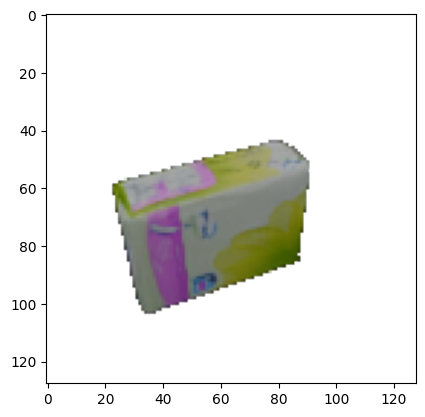

In [22]:
plt.imshow((X[i]).detach().cpu().permute(1,2,0))

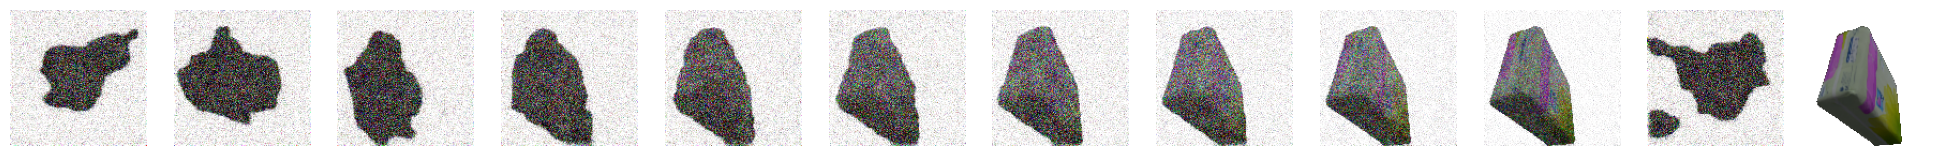

In [23]:
fig, axs = plt.subplots(1,12, figsize=(25, 12*25))
for e in range(12):
    axs[e].axis('off')
    axs[e].imshow(show[e].permute(1,2,0))